In [57]:
!pip install pandas
!pip install yfinance
!pip install scikit-learn
!pip install projectpro
!pip install keras-tuner

In [58]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

import yfinance as yf

import keras
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import os 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers import LSTM, SimpleRNN, Dense, Dropout
from keras.models import Sequential
from keras.layers import Dense

from tensorflow.keras import layers

from projectpro import model_snapshot, checkpoint
import pandas_ta as ta

import keras_tuner as kt
from kerastuner.tuners import RandomSearch

In [59]:
keras.backend.set_image_data_format("channels_last")
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
yf.pdr_override()
%matplotlib inline

In [60]:
now = datetime(year=2024, month=2, day=23)
start = now - relativedelta(years=10)
dataset = yf.download('NVDA', start, now)
print(dataset)

[*********************100%***********************]  1 of 1 completed
                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2014-02-24    4.650000    4.762500  ...    4.460093  40311200
2014-02-25    4.700000    4.720000  ...    4.439954  24218400
2014-02-26    4.675000    4.745000  ...    4.432845  36088400
2014-02-27    4.677500    4.725000  ...    4.383093  38884800
2014-02-28    4.600000    4.645000  ...    4.354662  32169200
...                ...         ...  ...         ...       ...
2024-02-15  738.690002  739.750000  ...  726.580017  42012200
2024-02-16  741.000000  744.020020  ...  726.130005  49391800
2024-02-20  719.469971  719.559998  ...  694.520020  70483300
2024-02-21  680.059998  688.880005  ...  674.719971  69029800
2024-02-22  750.250000  785.750000  ...  785.380005  86510000

[2517 rows x 6 columns]


In [61]:
def train_test_split(dataset, end, columns=['Close']):
    start_test = end - relativedelta(years=1)
    end_test = end

    end_train = start_test
    start_train = end_train - relativedelta(years=4)

    train = dataset.loc[start_train:end_train, columns].values
    test = dataset.loc[start_test:end_test, columns].values
    
    return train, test

In [62]:
mv_features = 6

In [63]:
multi_variate_df = yf.download('NVDA', start, now)

[*********************100%***********************]  1 of 1 completed


In [64]:
multi_variate_df['RSI'] = ta.rsi(multi_variate_df.Close, length=15)
multi_variate_df['EMAF'] = ta.ema(multi_variate_df.Close, length=20)
multi_variate_df['EMAM'] = ta.ema(multi_variate_df.Close, length=100)
multi_variate_df['EMAS'] = ta.ema(multi_variate_df.Close, length=150)

In [65]:
multi_variate_df['Target'] = multi_variate_df['Adj Close'] - dataset.Open
multi_variate_df['Target'] = multi_variate_df['Target'].shift(-1)
multi_variate_df.dropna(inplace=True)
multi_variate_df.drop(['Volume', 'Close'], axis=1, inplace=True)

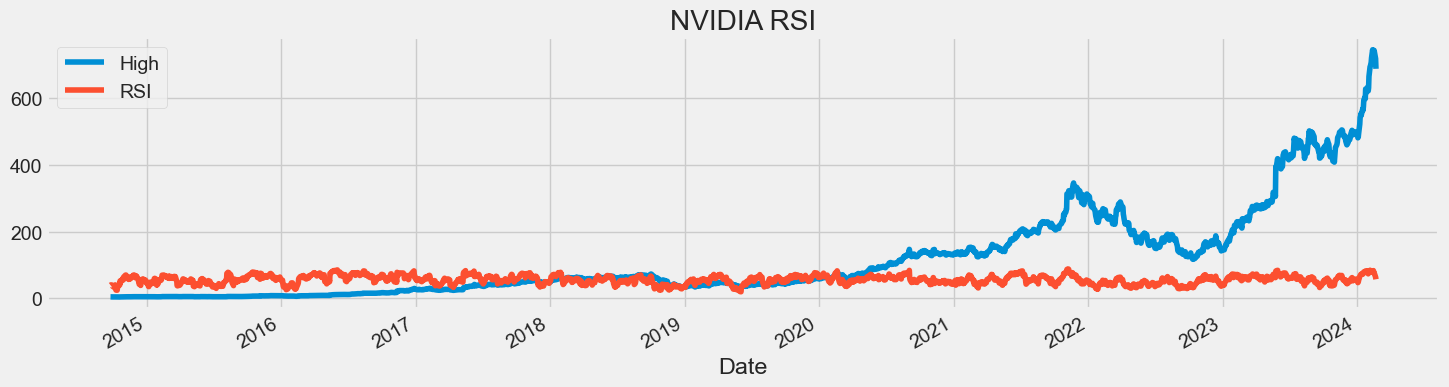

In [66]:
multi_variate_df.loc[f"{start}":f"{now}", ['High', 'RSI']].plot(figsize=(16, 4), legend=True)
plt.title("NVIDIA RSI")
plt.show()

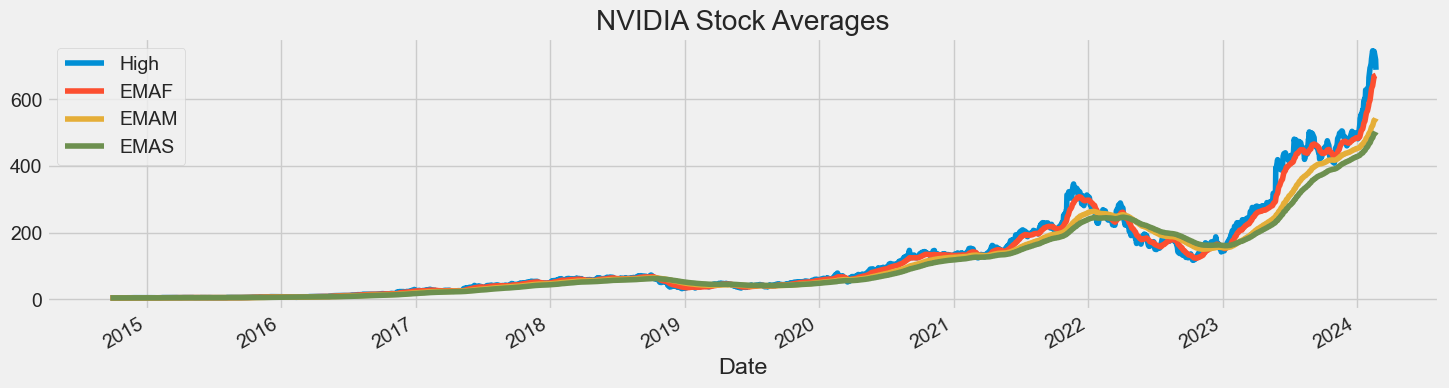

In [67]:
multi_variate_df.loc[f"{start}":f"{now}", ['High', 'EMAF', 'EMAM', 'EMAS']].plot(figsize=(16, 4), legend=True)
plt.title("NVIDIA Stock Averages")
plt.show()

In [68]:
feat_columns = ['Open', 'High', 'RSI', 'EMAF', 'EMAM', 'EMAS']
label_col = ['Target']

In [69]:
mv_training_set, mv_test_set = train_test_split(multi_variate_df, now, feat_columns + label_col)

In [70]:
X_train = mv_training_set[:, :-1]
y_train = mv_training_set[:, -1]

X_test = mv_test_set[:, :-1]
y_test = mv_test_set[:, -1]

In [71]:
mv_sc = MinMaxScaler(feature_range=(0, 1))
X_train = mv_sc.fit_transform(X_train).reshape(-1, 1, mv_features)
X_test = mv_sc.transform(X_test).reshape(-1, 1, mv_features)

In [72]:
# taking data from past 100 days for prediction
time_step = 100

In [73]:
def build_model(hp):
    model = Sequential()
    model.add(layers.LSTM(units = hp.Choice('layer1_units', [10,20,30,40,50,60,70,80,90,100]),return_sequences=True,input_shape=(100,1)))
    
    for i in range(hp.Int('num_layers', 2, 15)):                        
        model.add(layers.LSTM(units =  hp.Int('units' + str(i), min_value=10, max_value=150, step=10), return_sequences=True))
    
    model.add(LSTM(units = hp.Choice('last_lstm_units', [50, 100, 150])))
    model.add(Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5, 0.6, 0.7])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam' )
    return model


tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials= 5,
    executions_per_trial=3,
    directory='project', project_name = 'Stacked_LSTM_Stock_Prediction')

tuner.search_space_summary()

tuner.search(X_train, y_train,
             epochs= 5,
             validation_data=(X_test, y_test))

Reloading Tuner from project\Stacked_LSTM_Stock_Prediction\tuner0.json
Search space summary
Default search space size: 19
layer1_units (Choice)
{'default': 10, 'conditions': [], 'values': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'ordered': True}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 15, 'step': 1, 'sampling': 'linear'}
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 150, 'step': 10, 'sampling': 'linear'}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 150, 'step': 10, 'sampling': 'linear'}
last_lstm_units (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 150], 'ordered': True}
rate (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5, 0.6, 0.7], 'ordered': True}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 150, 'step': 10, 'sampling': 'linear'}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_val

In [74]:
tuner.results_summary()

Results summary
Results in project\Stacked_LSTM_Stock_Prediction
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 4 summary
Hyperparameters:
layer1_units: 30
num_layers: 15
units0: 80
units1: 90
last_lstm_units: 50
rate: 0.7
units2: 90
units3: 90
units4: 50
units5: 70
units6: 140
units7: 130
units8: 70
units9: 70
units10: 40
units11: 60
units12: 90
units13: 30
units14: 10
Score: 85.18013000488281

Trial 3 summary
Hyperparameters:
layer1_units: 60
num_layers: 10
units0: 40
units1: 90
last_lstm_units: 150
rate: 0.6
units2: 100
units3: 10
units4: 20
units5: 60
units6: 130
units7: 10
units8: 130
units9: 90
units10: 130
units11: 70
units12: 140
units13: 40
Score: 85.1868896484375

Trial 2 summary
Hyperparameters:
layer1_units: 30
num_layers: 9
units0: 140
units1: 60
last_lstm_units: 100
rate: 0.4
units2: 90
units3: 60
units4: 30
units5: 40
units6: 20
units7: 30
units8: 110
units9: 90
units10: 50
units11: 100
units12: 70
units13: 90
Score: 85.19453684488933

Trial 0 

In [75]:
model=tuner.get_best_models(num_models=1)[0]
model.summary()

ValueError: Received incompatible tensor with shape (6, 120) when attempting to restore variable with shape (1, 120) and name lstm/lstm_cell/kernel:0.

In [ ]:
model_history = model.fit(X_train,y_train, epochs=100, validation_data=(X_test,y_test))

In [ ]:
loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']



plt.figure(figsize=(17, 7))
plt.plot(range(100), loss, label='Training Loss')
plt.plot(range(100), validation_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Loss : Training Vs Validation ')

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)